# **DeepLab V3+**

In [ ]:
import torch
import torch.nn as nn
from skimage.io import imread
from torch.utils import data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import pathlib
import torchvision.transforms.functional as fn
from torchvision.io import read_image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import numpy as np
import re
import sys

In [22]:
!pip install segmentation-models-pytorch

  Using cached segmentation_models_pytorch-0.3.0-py3-none-any.whl (97 kB)
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)


In [38]:
!pip install --upgrade certifi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.6.15.2
    Uninstalling certifi-2022.6.15.2:
      Successfully uninstalled certifi-2022.6.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
google-api-core 1.33.0 requires protobuf<4.0.0dev,>=3.20.1, but you have protobuf 3.19.4 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.8.2 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you hav

In [39]:
transform = transforms.Grayscale()

In [24]:
class SegmentationDataSet2(data.Dataset):
    """Image segmentation dataset with caching and pretransforms."""
    def __init__(self,
                 inputs: list,
                 targets: list,
                 transform=None,
                 use_cache=False,
                 pre_transform=None,
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32
        self.use_cache = use_cache
        self.pre_transform = pre_transform

        if self.use_cache:
            self.cached_data = []

            progressbar = tqdm(range(len(self.inputs)), desc='Caching')
            for i, img_name, tar_name in zip(progressbar, self.inputs, self.targets):
                img, tar = imread(str(img_name)), imread(str(tar_name))
                if self.pre_transform is not None:
                    img, tar = self.pre_transform(img, tar)

                self.cached_data.append((img, tar))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        if self.use_cache:
            x, y = self.cached_data[index]
        else:
            # Select the sample
            input_ID = self.inputs[index]
            target_ID = self.targets[index]

            # Load input and target
            x, y = read_image(input_ID), read_image(target_ID)
            x, y = x.type(self.inputs_dtype), y.type(self.targets_dtype)
            x = (x - torch.min(x)) / (torch.max(x)-torch.min(x))
            y = transform(y)
            x,y = fn.resize(x,size=[512,512]),fn.resize(y,size=[512,512])
            y[y>0]=1

        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        return x, y

**Load the data**

In [25]:
inputs = []
dir1 =  '../input/final-contrail-dataset/FinalData/FalseColor'
for root, dirs, files in os.walk(dir1):
    inputs.extend(files)
inputs = sorted(inputs)
        
# read annotations
target = []
dir2 = '../input/final-contrail-dataset/FinalData/Contrail'
for root, dirs, files in os.walk(dir2):
    target.extend(files)
target = sorted(target)
inp = []
tar = []
for x in inputs:
    inp.append('../input/final-contrail-dataset/FinalData/FalseColor/'+x)
for x in target:
    tar.append('../input/final-contrail-dataset/FinalData/Contrail/'+x)
inputs = inp
target = tar

In [26]:
inp[0:5]

['../input/final-contrail-dataset/FinalData/FalseColor/1fci0.jpg',
 '../input/final-contrail-dataset/FinalData/FalseColor/1fci1.jpg',
 '../input/final-contrail-dataset/FinalData/FalseColor/1fci10.jpg',
 '../input/final-contrail-dataset/FinalData/FalseColor/1fci100.jpg',
 '../input/final-contrail-dataset/FinalData/FalseColor/1fci101.jpg']

**Remove all the images and masks that thave no contrails**

In [27]:
input_true = []
target_true = []
for count, value in enumerate(tar):
    y = read_image(value)
    y = transform(y)
    y[y>0]=1 
    if(len(y.unique())>1):
        input_true.append(inp[count])
        target_true.append(tar[count])
    if(count%100==0):
        print(count)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200


In [28]:
len(input_true)

2171

**Train Test split and Dataloader**

In [32]:
writer = SummaryWriter()

random_seed = 60

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    input_true,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    target_true,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# dataset training
dataset_train = SegmentationDataSet2(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=None)

# dataset validation
dataset_valid = SegmentationDataSet2(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=None)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=4,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=4,
                                   shuffle=True)

In [33]:
##Trying out the data loaded
batch = dataset_train[114]
x, y = batch

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
print(f'y = min: {y.min()}; max: {y.max()}')
#Getting the next batch::  x, y = next(iter(dataloader_training))

x = shape: torch.Size([3, 512, 512]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([1, 512, 512]); class: tensor([0., 1.]); type: torch.float32
y = min: 0.0; max: 1.0


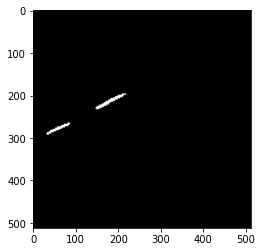

In [34]:
x,y = dataset_valid[114]
# print(y.shape)
plt.imshow(y.reshape(512,512), cmap='gray')
#y[1]
#plt.imshow(x.permute(1, 2, 0))

In [35]:
import segmentation_models_pytorch as smp

**Create segmentation model with pretrained encoder**

In [36]:
ENCODER = 'resnext101_32x4d'#'tu-xception71' #'resnet101'
ENCODER_WEIGHTS = 'ssl' #'imagenet'#uncomment if xception or resnet101
ACTIVATION = 'sigmoid' 

model = smp.DeepLabV3Plus(
     encoder_name=ENCODER, 
     encoder_weights=ENCODER_WEIGHTS, 
     classes=1, 
     activation=ACTIVATION,
 )

Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x4-dc43570a.pth" to /root/.cache/torch/hub/checkpoints/semi_supervised_resnext101_32x4-dc43570a.pth


  0%|          | 0.00/169M [00:00<?, ?B/s]

In [37]:
from segmentation_models_pytorch.utils import *

**Losses**

In [40]:
epsilon = 1e-5
smooth = 1
DiceLoss=smp.utils.losses.DiceLoss()

def tversky(y_pred, y_true):
    y_true_pos = torch.flatten(y_true)
    y_pred_pos = torch.flatten(y_pred)
    true_pos = torch.sum(y_true_pos * y_pred_pos)
    false_neg = torch.sum(y_true_pos * (1-y_pred_pos))
    false_pos = torch.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss( y_pred,y_true):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_pred,y_true):
    pt_1 = tversky(y_pred,y_true)
    gamma = 0.75
    return torch.pow((1-pt_1), gamma)
class Focal_Tversky(base.Loss):
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        #self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        #y_pr = self.activation(y_pr)
        return 0.5*focal_tversky(y_pr,y_gt) + 0.5*DiceLoss(y_pr,y_gt)

In [41]:
writer = SummaryWriter('dlv3+')

In [42]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set number of epochs
EPOCHS = 50

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Loss Function
loss = Focal_Tversky()

#Metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

#Optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

**Creating training and validation epoch**

In [43]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [44]:
torch.cuda.empty_cache()

**Train the model**

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(dataloader_training)
        valid_logs = valid_epoch.run(dataloader_validation)
        train_logs_list.append(train_logs)
        writer.add_scalar("Loss/train", train_logs['focal__tversky'], i)
        writer.add_scalar("IOU/train", train_logs['iou_score'], i)
        valid_logs_list.append(valid_logs)
        writer.add_scalar("Loss/valid", valid_logs['focal__tversky'], i)
        writer.add_scalar("IOU/valid", valid_logs['iou_score'], i)

        #Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_modelv3plus.pth')
            print('Model saved!')
writer.flush()